# Ejemplos de Redes Neuronales: Thalamus e Hippocampus

Partiendo del modelo descrito en la Introducción, se puede pasar a ilustrar ejemplos con los modelos desarrollados. Como ya se explicó previamente, en numerosos lugares en el cerebro dos células interactúan, una inhibitoria y la otra excitatoria, en tal forma que una dispara una rápida ráfaga de potenciales de acción seguido por  un pulso bajo disparado por la otra. Por tanto, dos escalas de tiempo están envueltas. Los modelos que describimos a continuación reproducen dichos fenómenos.

## Circuito Thalamocortical

Muchas señalas de entrada al cerebro son procesados en el Thalamus, el cual ordena las señales para su posterior procesamiento en otras estructuras cerebrales como son la corteza entorhinal en el hippocampus (Una descripción más detallada de este sistema neuronal se puede encontrar [aquí](http://www.scholarpedia.org/article/Models_of_thalamocortical_system)). Ésto envuelve un circuito entre células excitatorias e inhibitorias en una estructura paralela llamada el complejo reticular. Las células thalamicas disparan repidamente, y el complejo reticular dispara lentamente. La red para este sistema se presenta en el siguiente diagrama.

$$\sigma\rightarrow^{+}TH\mbox{  }^{-}\leftrightarrow^{+}RC\rightarrow^{+}NC$$

Ahora bien, para modelar el flujo de estímulos podemos simularlo con las siguientes expresiones:

$$\dot{x}=5.0(1+\sigma+\cos x-\cos y)\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(A)$$

$$\dot{y}=0.04(1+\cos y+10\cos x)\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(B)$$



Necesitaremos algunas paqueterías:

In [2]:
using TaylorSeries

In [3]:
println(VERSION)

using Compat

0.

In [4]:
using PyPlot

Lo siguiente será resolver las ecuaciones anteriores usando el método de Integración de Taylor, para lo cual conviene desarrollar las funciones que serán de gran ayuda, no sólo en este momento sino también más adelante. Como se estudió en clase: necesitamos establecer condiciones iniciales $x(t_{0})$ y $y(t_{0})$, las cuales emplearemos para obtener cada término de la expansión de Taylor de forma recursiva, usando:

$$x_{n+1}=\frac{f_{n}(x)}{n+1}\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(1)$$

donde $f_{n}(x)$ es el $n$-ésimo coeficiente de $f(x)$, siendo $\dot{x}=f(x)$. De igual forma, $x_{n}$ es el $n$-ésimo coeficiente para la variable $x(t)$, alrededor de $x_{0}=x(t_{0})$

Por otro lado, como ya sabemos, los últimos dos términos de la expansión son usados para determinar el tamaño de paso $h$ para la integración junto con el valor de $\epsilon$, es decir:

$$h=min\left[\left(\frac{\epsilon}{|x_{k-1}|} \right)^{1/(k-1)},\left(\frac{\epsilon}{|x_{k}|} \right)^{1/k}\right]$$

donde $k$ es el orden del polinomio de Taylor.

Por tanto, debemos construir la función de paso para el método de Taylor, la cual estará dada por:

In [5]:
# Función paso: determina el tamaño de paso para la integración
# por método de Taylor.
function paso{T<:Real}(x::Taylor1{T}, epsilon::Float64)# Se introduce un polinomio de Taylor y el epsilon
    k = x.order# Orden del polinomio
    h = 1.0# Iniciamos h
    for i in [k-1, k]# Iteramos solo para los dos primeros términos del polinomio
        aux = abs( x.coeffs[i+1] )
        h = min(h, (epsilon/aux)^(1.0/i))# Nos quedamos con el mínimo
    end
    return h # La función devuelve h
end

4.1


paso (generic function with 1 method)

Igualmente se requiere de una función que determine los coeficientes en cada paso, usaremos la función evaluador:

In [6]:
# Función evaluador: Determina los coeficientes después de cada paso.
function evaluador{T<:Real}( Eqs::Function, vec0::Array{T,1}, N::Int, epsilon::Float64, σ, t)# La función solicita las ecuaciones
    # a resolver, un arreglo de condiciones iniciales, N que indica el máximo coeficiente de expansión y la epsilón.
    
    n = length(vec0)# Definimos algunas cantidades de utilidad
    vec1T = Eqs(vec0, N, σ, t)# Resolvemos las ecuaciones con las condiciones iniciales
    
    # Obtenemos h para cada serie usando la función paso
    hh = vec0
    for i in eachindex(vec1T)
        hh[i] = paso(vec1T[i], epsilon)
    end
    
    # Tomamos el mínimo de los h's
    hfin = hh[1]
    for i in eachindex(hh)
        hfin = min(hfin,hh[i])
    end
    
    # Se determinan los valores del nuevo arreglo
    for i=1:n
        vec0[i] = evaluate(vec1T[i], hfin)
    end
    
    return hfin, vec0# Devolvemos los resultados
end

evaluador (generic function with 1 method)

La función anterior es suficiente para poder empezar a trabajar con el método de Integración de Taylor para resolver el sistema de ecuaciones dierenciales anterior. Lo siguiente es darle condiciones iniciales a nuestro problema, en particular asumiremos un estado de reposo en el sistema, es decir: $x(0)=0$ y $y(0)=0$. Usaremos una función para escribir las condiciones iniciales, ésto permitirá cambiarlas a nuestro justo para ejemplificar más casos:

In [7]:
# Función Cond0: devuelve las condiciones iniciales.
function Cond0{T<:Real}(α::T, β::T)# El usuario puede introducir las condiciones iniciales que desee
    x0  = α
    y0  = β
    return x0, y0# Y la función, claro, devolverá tales condiciones iniciales
end

Cond0 (generic function with 1 method)

Paso siguiente, necesitamos una función que obtenga el polinomio de Taylor usando la ecuación de recurrencia (1), a continuación se presenta tal función:

In [8]:
# Función ThalaFun: determina los coeficientes de la series de Taylor según las ecuaciones (A) y (B).
function ThalaFun{T<:Real}(vec::Array{T,1} , N::Int, σ, t) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor y σ
    xT = Taylor1(vec[1], N)# Los primeros términos de la serie x0 y y0 
    yT = Taylor1(vec[2], N)

    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        xTt = Taylor1( xT.coeffs[1:k+1], k)
        yTt = Taylor1( yT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas por (A) y (B)
        Dx = 5.0*(1.0+σ+cos(xTt)-cos(yTt))
        Dy = 0.04*(1.0+cos(yTt)+10.0*cos(xTt))
        # Los términos k+1 están determinados por (1)
        xT.coeffs[knext+1]  = Dx.coeffs[knext] / knext
        yT.coeffs[knext+1]  = Dy.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[xT, yT]
end

ThalaFun (generic function with 1 method)

Con lo anterior podemos pasar a realizar la integración con el método de Taylor, ésto es:

In [9]:
# Función Integrador1: contiene las ecuaciones a resolver usando el método de integración de Taylor
function Integrador1( α::Float64, β::Float64, t_max::Float64, Eqs::Function, epsilon::Float64, N::Int )
    # Usará las funciones antes desarrolladas, este función pide un tiempo máximo de operación, las ecuaciones
    # a resolver, el epsilón y el orden del polinomio de Taylor
    t0 = 0.0# Iniciamos el tiempo
    x0, y0 = Cond0(α, β)# Condiciones iniciales
    
    σ = 0.5 # Probaremos con un valor de 0.5 para sigma
    
    tV, xV, yV = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    push!(tV, t0)
    push!(xV, x0)# COlocamos condiciones iniciales
    push!(yV, y0)

    # Resolvemos para cada tiempo
    dt = 1.0# Paso inicial
    while t0 < t_max && dt>1.0e-8# Condiciones de paro
        
        dt, res = evaluador( Eqs, [x0, y0], N, epsilon, σ ,t0)# Resolvemos
        t0 += dt# A t0 se le suma el tamaño de paso
        push!(tV,t0)
        push!(xV,res[1])# Los resultados se guardan
        push!(yV,res[2])
        x0, y0 = res[1], res[2]# Nuevas condiciones iniciales
    end

    return tV, xV, yV# Devuelve los resultados
end

Integrador1 (generic function with 1 method)

Con esto último tenemos lo necesario para resolver nuestro sistema de ecuaciones, manos a la obra:

In [10]:
Tres,Xres,Yres=Integrador1(0.0,0.0,300.0,ThalaFun,10.0^(-10),20);

Hasta este punto hemos logrado resolver el sistema de ecuaciones diferenciales, ahora estudiemos nuestros resultados. Sin embargo para poder dar una mejor interpretación de ellos conviene mostrar el coseno de $x$ y $y$ como una función del tiempo, es decir mostraremos $\cos x(t)$ y $\cos y(t)$. Entonces:

In [11]:
cosX = Xres
cosY = Yres
for i in eachindex(Xres)
    cosX[i] = cos(Xres[i])
    cosY[i] = cos(Yres[i])
end

Grafiquemos:

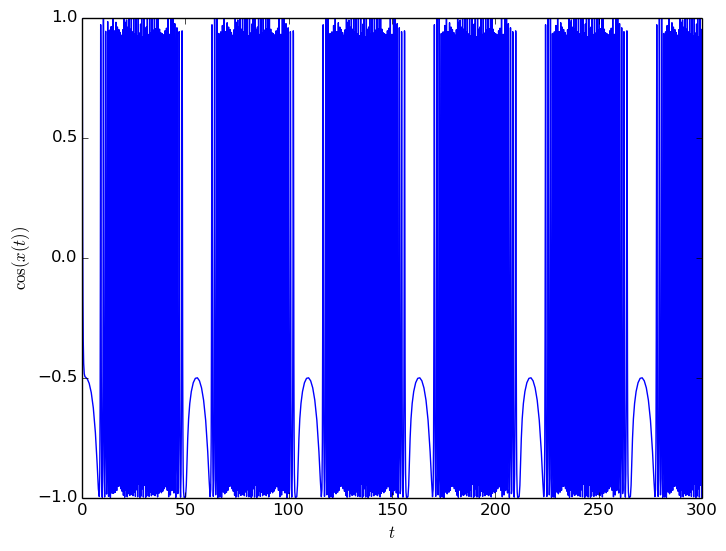

In [12]:
plot(Tres,cosX)
xlim([0.0,300.0])
xlabel(L"$t$")
ylabel(L"$\cos(x(t))$")
show()

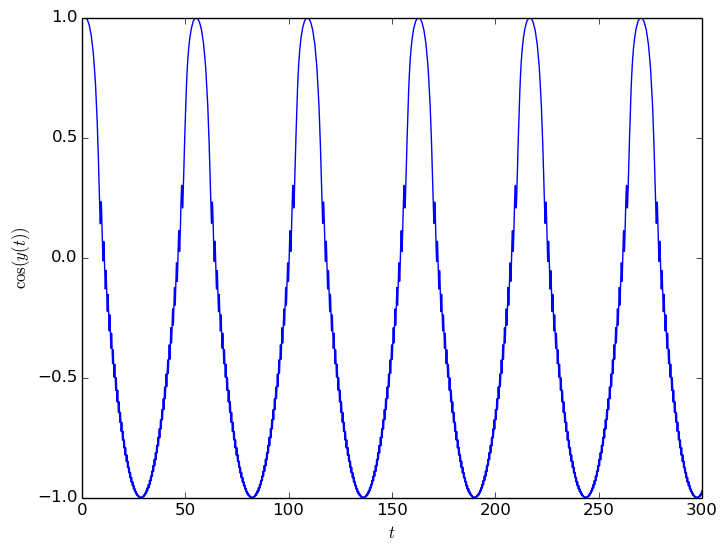

In [13]:
plot(Tres,cosY)
xlim([0.0,300.0])
xlabel(L"$t$")
ylabel(L"$\cos(y(t))$")
show()

En base a lo anterior, se puede proponer que el cerebro enfoca la atención en los estímulos más persistentes usando un circuito en el thalamus. Para darle un enfoque más general simulamos un circuito electrónico construido con el oscilador de atoll, en el cual se tendrán diferentes señales llegando al thalamus.

Cuando estímulos de varias intensidad llegan al thalamus, este sólo parará le estímulos más demandantes a la neocorteza para su posterior procesamiento. Una ceálula del thalamus excita una célula del complejo reitucular, la cual retroalimenta inhibiciones a las células thalamicas en tal forma que ráfadas repetitivas son observadas como en el modelo de atoll. En la Figura anterior, la ctividad del par efectivamente inhibe otras células RC cercanas, y éste excita una sola estrcutura neocortical. En el caso de la red completa, se tiene un complejo como el de la siguiente forma:

Las fases de los voltajes son denotados por $x_{i}$ y $y_{i}$, donde $i={1,2,3,....,N}$, para las células TH y RC, respectivamente. Las fases de las proyecciones neocorticales son $z_{i}$. Un modelo para esta red se puede describir con las ecuaciones:

$$x_{i}=5(1+cos x_{i}-\cos_{+}y_{i}+\sigma_{i}(t))\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(C)$$

$$y_{i}=0.04(1+cos y_{i}+\tanh(2\cos_{+}x_{i}-10L(t)))\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(D)$$

$$z_{i}=10(0.1+cos z_{i}-\cos_{+}y_{i})\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(E)$$

Donde $L$ considera la inhibición lateral en el complejo reticular. Siendo $a_{+}=(a+|a|)/2$ es la parte positiva de $a$. Las constatens en esta red son escojidas para tener una razón de escalas de timepo de aproximadamente 100:1. Términos positivos son unos excitatorios y las negativos son inhibitorios. 

En una aproximación se puede considerar:

$$L(t)=\frac{1}{N}\sum_{k=1}^{N}\cos_{+}y_{k}$$

el cual representa la inhibición lateral en el complejo reticular. En este programa, desarrollamos un sistema de tres neuronas usando las funciones anteriores, sólo es necesario definir la función que considere todas las variables junto con una función de condiciones iniciales, en eset caso se introducirá un arreglo de condiciones iniciales, el cual se escribirá de la siguiente forma:

In [14]:
# Arreglo de condiciones iniciales.
CondTC1 = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0];
CondTC2 = [π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0,π/2.0,0.0,π/2.0];
CondTC3 = [0.0,0.0,π/2.0,0.0,0.0,π/2.0,0.0,0.0,π/2.0,0.0,0.0,π/2.0,0.0,0.0,π/2.0,0.0,0.0,π/2.0,0.0,0.0,π/2.0,0.0,0.0,π/2.0,0.0,0.0,π/2.0];

Para facilitar, creamos una función que determine $a_{+}$ para un Taylor, se tendrá:

In [15]:
# Función d: determina la parte positiva de una función.
function d{T<:Real}(x::Taylor1{T}) # La función pide un Taylor
    res=(x+((x^2)^0.5))/2.0
    return res
end    

d (generic function with 1 method)

Ya que la paquetería a emplear no tiene definida la función $\tanh$ nos conviene escribirla en términos de exponenciales, creamos la función que calcula la $\tanh$, se tendrá:

In [16]:
# Función tanh1: Determina la tanh para un Taylor
function tanh1{T<:Real}(x::Taylor1{T}) # La función pide un Taylor
    ap1 = exp(2.0*(x))
    res1 = (ap1-1.0)/(ap1+1.0)
    return res1
end    

tanh1 (generic function with 1 method)

Lo siguiente es definir la función que incluya las ecuaciones anteriores:

In [17]:
# Función ThalaFunCom: determina los coeficientes de la series de Taylor según las ecuaciones de las células
# TH y RC.
function ThalaFunCom{T<:Real}(vec::Array{T,1} , N::Int, σ, t) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor y σ
    x1T = Taylor1(vec[1], N)# Los primeros términos de la serie x0i, y0i y z0i
    y1T = Taylor1(vec[2], N)
    z1T = Taylor1(vec[3], N)
    x2T = Taylor1(vec[4], N)
    y2T = Taylor1(vec[5], N)
    z2T = Taylor1(vec[6], N)
    x3T = Taylor1(vec[7], N)
    y3T = Taylor1(vec[8], N)
    z3T = Taylor1(vec[9], N)
    x4T = Taylor1(vec[10], N)# Los primeros términos de la serie x0i, y0i y z0i
    y4T = Taylor1(vec[11], N)
    z4T = Taylor1(vec[12], N)
    x5T = Taylor1(vec[13], N)
    y5T = Taylor1(vec[14], N)
    z5T = Taylor1(vec[15], N)
    x6T = Taylor1(vec[16], N)
    y6T = Taylor1(vec[17], N)
    z6T = Taylor1(vec[18], N)
    x7T = Taylor1(vec[19], N)# Los primeros términos de la serie x0i, y0i y z0i
    y7T = Taylor1(vec[20], N)
    z7T = Taylor1(vec[21], N)
    x8T = Taylor1(vec[22], N)
    y8T = Taylor1(vec[23], N)
    z8T = Taylor1(vec[24], N)
    x9T = Taylor1(vec[25], N)
    y9T = Taylor1(vec[26], N)
    z9T = Taylor1(vec[27], N)
    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        x1Tt = Taylor1( x1T.coeffs[1:k+1], k)
        y1Tt = Taylor1( y1T.coeffs[1:k+1], k)
        z1Tt = Taylor1( z1T.coeffs[1:k+1], k)
        x2Tt = Taylor1( x2T.coeffs[1:k+1], k)
        y2Tt = Taylor1( y2T.coeffs[1:k+1], k)
        z2Tt = Taylor1( z2T.coeffs[1:k+1], k)
        x3Tt = Taylor1( x3T.coeffs[1:k+1], k)
        y3Tt = Taylor1( y3T.coeffs[1:k+1], k)
        z3Tt = Taylor1( z3T.coeffs[1:k+1], k)
        x4Tt = Taylor1( x4T.coeffs[1:k+1], k)
        y4Tt = Taylor1( y4T.coeffs[1:k+1], k)
        z4Tt = Taylor1( z4T.coeffs[1:k+1], k)
        x5Tt = Taylor1( x5T.coeffs[1:k+1], k)
        y5Tt = Taylor1( y5T.coeffs[1:k+1], k)
        z5Tt = Taylor1( z5T.coeffs[1:k+1], k)
        x6Tt = Taylor1( x6T.coeffs[1:k+1], k)
        y6Tt = Taylor1( y6T.coeffs[1:k+1], k)
        z6Tt = Taylor1( z6T.coeffs[1:k+1], k)
        x7Tt = Taylor1( x7T.coeffs[1:k+1], k)
        y7Tt = Taylor1( y7T.coeffs[1:k+1], k)
        z7Tt = Taylor1( z7T.coeffs[1:k+1], k)
        x8Tt = Taylor1( x8T.coeffs[1:k+1], k)
        y8Tt = Taylor1( y8T.coeffs[1:k+1], k)
        z8Tt = Taylor1( z8T.coeffs[1:k+1], k)
        x9Tt = Taylor1( x9T.coeffs[1:k+1], k)
        y9Tt = Taylor1( y9T.coeffs[1:k+1], k)
        z9Tt = Taylor1( z9T.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas por (C), (D) y (E)
        Lyi = (1.0/9.0)*(d(cos(y1Tt))+d(cos(y2Tt))+d(cos(y3Tt)))
        Lyi = Lyi+(1.0/9.0)*(d(cos(y4Tt))+d(cos(y5Tt))+d(cos(y6Tt)))
        Lyi = Lyi+(1.0/9.0)*(d(cos(y7Tt))+d(cos(y8Tt))+d(cos(y9Tt)))
        Dx1 = 5.0*(1.0+cos(x1Tt)-d(cos(y1Tt))+σ[1])
        Dy1 = 0.04*(1.0+cos(y1Tt)+tanh1(2.0*d(cos(x1Tt)-10.0*Lyi)))
        Dz1 = 10.0*(0.1+cos(z1Tt)-d(cos(y1Tt)))
        Dx2 = 5.0*(1.0+cos(x2Tt)-d(cos(y2Tt))+σ[2])
        Dy2 = 0.04*(1.0+cos(y2Tt)+tanh1(2.0*d(cos(x2Tt)-10.0*Lyi)))
        Dz2 = 10.0*(0.1+cos(z2Tt)-d(cos(y2Tt)))
        Dx3 = 5.0*(1.0+cos(x3Tt)-d(cos(y3Tt))+σ[3])
        Dy3 = 0.04*(1.0+cos(y3Tt)+tanh1(2.0*d(cos(x3Tt)-10.0*Lyi)))
        Dz3 = 10.0*(0.1+cos(z3Tt)-d(cos(y3Tt)))
        Dx4 = 5.0*(1.0+cos(x4Tt)-d(cos(y4Tt))+σ[4])
        Dy4 = 0.04*(1.0+cos(y4Tt)+tanh1(2.0*d(cos(x4Tt)-10.0*Lyi)))
        Dz4 = 10.0*(0.1+cos(z4Tt)-d(cos(y4Tt)))
        Dx5 = 5.0*(1.0+cos(x5Tt)-d(cos(y5Tt))+σ[5])
        Dy5 = 0.04*(1.0+cos(y5Tt)+tanh1(2.0*d(cos(x5Tt)-10.0*Lyi)))
        Dz5 = 10.0*(0.1+cos(z5Tt)-d(cos(y5Tt)))
        Dx6 = 5.0*(1.0+cos(x6Tt)-d(cos(y6Tt))+σ[6])
        Dy6 = 0.04*(1.0+cos(y6Tt)+tanh1(2.0*d(cos(x6Tt)-10.0*Lyi)))
        Dz6 = 10.0*(0.1+cos(z6Tt)-d(cos(y6Tt)))
        Dx7 = 5.0*(1.0+cos(x7Tt)-d(cos(y7Tt))+σ[7])
        Dy7 = 0.04*(1.0+cos(y7Tt)+tanh1(2.0*d(cos(x7Tt)-10.0*Lyi)))
        Dz7 = 10.0*(0.1+cos(z7Tt)-d(cos(y7Tt)))
        Dx8 = 5.0*(1.0+cos(x8Tt)-d(cos(y8Tt))+σ[8])
        Dy8 = 0.04*(1.0+cos(y8Tt)+tanh1(2.0*d(cos(x8Tt)-10.0*Lyi)))
        Dz8 = 10.0*(0.1+cos(z8Tt)-d(cos(y8Tt)))
        Dx9 = 5.0*(1.0+cos(x9Tt)-d(cos(y9Tt))+σ[9])
        Dy9 = 0.04*(1.0+cos(y9Tt)+tanh1(2.0*d(cos(x9Tt)-10.0*Lyi)))
        Dz9 = 10.0*(0.1+cos(z9Tt)-d(cos(y9Tt)))
        # Los términos k+1 están determinados por (1)
        x1T.coeffs[knext+1]  = Dx1.coeffs[knext] / knext
        y1T.coeffs[knext+1]  = Dy1.coeffs[knext] / knext
        z1T.coeffs[knext+1]  = Dz1.coeffs[knext] / knext
        x2T.coeffs[knext+1]  = Dx2.coeffs[knext] / knext
        y2T.coeffs[knext+1]  = Dy2.coeffs[knext] / knext
        z2T.coeffs[knext+1]  = Dz2.coeffs[knext] / knext
        x3T.coeffs[knext+1]  = Dx3.coeffs[knext] / knext
        y3T.coeffs[knext+1]  = Dy3.coeffs[knext] / knext
        z3T.coeffs[knext+1]  = Dz3.coeffs[knext] / knext
        x4T.coeffs[knext+1]  = Dx4.coeffs[knext] / knext
        y4T.coeffs[knext+1]  = Dy4.coeffs[knext] / knext
        z4T.coeffs[knext+1]  = Dz4.coeffs[knext] / knext
        x5T.coeffs[knext+1]  = Dx5.coeffs[knext] / knext
        y5T.coeffs[knext+1]  = Dy5.coeffs[knext] / knext
        z5T.coeffs[knext+1]  = Dz5.coeffs[knext] / knext
        x6T.coeffs[knext+1]  = Dx6.coeffs[knext] / knext
        y6T.coeffs[knext+1]  = Dy6.coeffs[knext] / knext
        z6T.coeffs[knext+1]  = Dz6.coeffs[knext] / knext
        x7T.coeffs[knext+1]  = Dx7.coeffs[knext] / knext
        y7T.coeffs[knext+1]  = Dy7.coeffs[knext] / knext
        z7T.coeffs[knext+1]  = Dz7.coeffs[knext] / knext
        x8T.coeffs[knext+1]  = Dx8.coeffs[knext] / knext
        y8T.coeffs[knext+1]  = Dy8.coeffs[knext] / knext
        z8T.coeffs[knext+1]  = Dz8.coeffs[knext] / knext
        x9T.coeffs[knext+1]  = Dx9.coeffs[knext] / knext
        y9T.coeffs[knext+1]  = Dy9.coeffs[knext] / knext
        z9T.coeffs[knext+1]  = Dz9.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[x1T,y1T,z1T,x2T,y2T,z2T,x3T,y3T,z3T,x4T,y4T,z4T,x5T,y5T,z5T,x6T,y6T,z6T,x7T,y7T,z7T,x8T,y8T,z8T,x9T,y9T,z9T]
end

ThalaFunCom (generic function with 1 method)

Falta construir una función que realize la integración considerando los elementos anteriores:

In [18]:
# Función Integrador2: contiene las ecuaciones a resolver usando el método de integración de Taylor
function Integrador2{T<:Real}( vec::Array{T,1}, t_max::Float64, Eqs::Function, epsilon::Float64, N::Int )
    # Usará las funciones antes desarrolladas, este función pide un tiempo máximo de operación, las ecuaciones
    # a resolver, el epsilón y el orden del polinomio de Taylor
    t0 = 0.0# Iniciamos el tiempo
    x10 = vec[1]
    y10 = vec[2]
    z10 = vec[3]
    x20 = vec[4]
    y20 = vec[5]
    z20 = vec[6]
    x30 = vec[7]
    y30 = vec[8]
    z30 = vec[9]
    x40 = vec[10]
    y40 = vec[11]
    z40 = vec[12]
    x50 = vec[13]
    y50 = vec[14]
    z50 = vec[15]
    x60 = vec[16]
    y60 = vec[17]
    z60 = vec[18]
    x70 = vec[19]
    y70 = vec[20]
    z70 = vec[21]
    x80 = vec[22]
    y80 = vec[23]
    z80 = vec[24]
    x90 = vec[25]
    y90 = vec[26]
    z90 = vec[27]
    
    σ = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    
    tV, x1V, y1V, z1V = Float64[], Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x2V, y2V, z2V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x3V, y3V, z3V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x4V, y4V, z4V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x5V, y5V, z5V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x6V, y6V, z6V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x7V, y7V, z7V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x8V, y8V, z8V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    x9V, y9V, z9V = Float64[], Float64[], Float64[]# Aquí se ubicarán los resultados
    push!(tV, t0)
    push!(x1V, x10)# COlocamos condiciones iniciales
    push!(y1V, y10)
    push!(z1V, z10)
    push!(x2V, x20)# COlocamos condiciones iniciales
    push!(y2V, y20)
    push!(z2V, z20)
    push!(x3V, x30)# COlocamos condiciones iniciales
    push!(y3V, y30)
    push!(z3V, z30)
    push!(x4V, x40)# COlocamos condiciones iniciales
    push!(y4V, y40)
    push!(z4V, z40)
    push!(x5V, x50)# COlocamos condiciones iniciales
    push!(y5V, y50)
    push!(z5V, z50)
    push!(x6V, x60)# COlocamos condiciones iniciales
    push!(y6V, y60)
    push!(z6V, z60)
    push!(x7V, x70)# COlocamos condiciones iniciales
    push!(y7V, y70)
    push!(z7V, z70)
    push!(x8V, x80)# COlocamos condiciones iniciales
    push!(y8V, y80)
    push!(z8V, z80)
    push!(x9V, x90)# COlocamos condiciones iniciales
    push!(y9V, y90)
    push!(z9V, z90)

    # Resolvemos para cada tiempo
    dt = 1.0# Paso inicial
    while t0 < t_max && dt>1.0e-8# Condiciones de paro
        if 600.0>t0 > 300.0
            σ = [0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0]
        end
        if 900.0>t0 > 600.0
            σ = [0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0]
        end
        if 1200.0>t0 > 900.0
            σ = [0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0]
        end
        if 1500.0>t0 > 1200.0
            σ = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9]
        end
        dt, res = evaluador(Eqs,[x10,y10,z10,x20,y20,z20,x30,y30,z30,x40,y40,z40,x50,y50,z50,x60,y60,z60,x70,y70,z70,x80,y80,z80,x90,y90,z90],N,epsilon,σ,t0)# Resolvemos
        t0 += dt# A t0 se le suma el tamaño de paso
        push!(tV,t0)
        push!(x1V,res[1])# Los resultados se guardan
        push!(y1V,res[2])
        push!(z1V,res[3])
        push!(x2V,res[4])# Los resultados se guardan
        push!(y2V,res[5])
        push!(z2V,res[6])
        push!(x3V,res[7])# Los resultados se guardan
        push!(y3V,res[8])
        push!(z3V,res[9])
        push!(x4V,res[10])# Los resultados se guardan
        push!(y4V,res[11])
        push!(z4V,res[12])
        push!(x5V,res[13])# Los resultados se guardan
        push!(y5V,res[14])
        push!(z5V,res[15])
        push!(x6V,res[16])# Los resultados se guardan
        push!(y6V,res[17])
        push!(z6V,res[18])
        push!(x7V,res[19])# Los resultados se guardan
        push!(y7V,res[20])
        push!(z7V,res[21])
        push!(x8V,res[22])# Los resultados se guardan
        push!(y8V,res[23])
        push!(z8V,res[24])
        push!(x9V,res[25])# Los resultados se guardan
        push!(y9V,res[26])
        push!(z9V,res[27])
        x10, y10, z10 = res[1], res[2], res[3]
        x20, y20, z20 = res[4], res[5], res[6]# Nuevas condiciones iniciales
        x30, y30, z30 = res[7], res[8], res[9]
        x40, y40, z40 = res[10], res[11], res[12]
        x50, y50, z50 = res[13], res[14], res[15]# Nuevas condiciones iniciales
        x60, y60, z60 = res[16], res[17], res[18]
        x70, y70, z70 = res[19], res[20], res[21]
        x80, y80, z80 = res[22], res[23], res[24]# Nuevas condiciones iniciales
        x90, y90, z90 = res[25], res[26], res[27]
    end

    return tV,x1V,y1V,z1V,x2V,y2V,z2V,x3V,y3V,z3V,x4V,y4V,z4V,x5V,y5V,z5V,x6V,y6V,z6V,x7V,y7V,z7V,x8V,y8V,z8V,x9V,y9V,z9V
end

Integrador2 (generic function with 1 method)

Con eso es suficiente para obtener resultados, corremos la función anterior:

In [19]:
resT,resX1,resY1,resZ1,resX2,resY2,resZ2,resX3,resY3,resZ3,resX4,resY4,resZ4,resX5,resY5,resZ5,resX6,resY6,resZ6,resX7,resY7,resZ7,resX8,resY8,resZ8,resX9,resY9,resZ9 = Integrador2(CondTC2, 2200.0, ThalaFunCom, 10.0^(-10), 20);

Ya tenemos los resultados, sin embargo de estos solo nos interesa el coseno, entonces:

In [20]:
cosX1 = resX1
cosY1 = resY1
cosZ1 = resZ1
cosX2 = resX2
cosY2 = resY2
cosZ2 = resZ2
cosX3 = resX3
cosY3 = resY3
cosZ3 = resZ3
cosX4 = resX4
cosY4 = resY4
cosZ4 = resZ4
cosX5 = resX5
cosY5 = resY5
cosZ5 = resZ5
cosX6 = resX6
cosY6 = resY6
cosZ6 = resZ6
cosX7 = resX7
cosY7 = resY7
cosZ7 = resZ7
cosX8 = resX8
cosY8 = resY8
cosZ8 = resZ8
cosX9 = resX9
cosY9 = resY9
cosZ9 = resZ9
for i in eachindex(resX1)
    cosX1[i] = (cos(resX1[i]))/2.0
    cosY1[i] = 10.0+(cos(resY1[i]))/2.0
    cosZ1[i] = 20.0+(cos(resZ1[i]))/2.0
    cosX2[i] = 1.0+(cos(resX2[i]))/2.0
    cosY2[i] = 11.0+(cos(resY2[i]))/2.0
    cosZ2[i] = 21.0+(cos(resZ2[i]))/2.0
    cosX3[i] = 2.0+(cos(resX3[i]))/2.0
    cosY3[i] = 12.0+(cos(resY3[i]))/2.0
    cosZ3[i] = 22.0+(cos(resZ3[i]))/2.0
    cosX4[i] = 3.0+(cos(resX4[i]))/2.0
    cosY4[i] = 13.0+(cos(resY4[i]))/2.0
    cosZ4[i] = 23.0+(cos(resZ4[i]))/2.0
    cosX5[i] = 4.0+(cos(resX5[i]))/2.0
    cosY5[i] = 14.0+(cos(resY5[i]))/2.0
    cosZ5[i] = 24.0+(cos(resZ5[i]))/2.0
    cosX6[i] = 5.0+(cos(resX6[i]))/2.0
    cosY6[i] = 15.0+(cos(resY6[i]))/2.0
    cosZ6[i] = 25.0+(cos(resZ6[i]))/2.0
    cosX7[i] = 6.0+(cos(resX7[i]))/2.0
    cosY7[i] = 16.0+(cos(resY7[i]))/2.0
    cosZ7[i] = 26.0+(cos(resZ7[i]))/2.0
    cosX8[i] = 7.0+(cos(resX8[i]))/2.0
    cosY8[i] = 17.0+(cos(resY8[i]))/2.0
    cosZ8[i] = 27.0+(cos(resZ8[i]))/2.0
    cosX9[i] = 8.0+(cos(resX9[i]))/2.0
    cosY9[i] = 18.0+(cos(resY9[i]))/2.0
    cosZ9[i] = 28.0+(cos(resZ9[i]))/2.0
end

Veamos lo que se obtuvo:

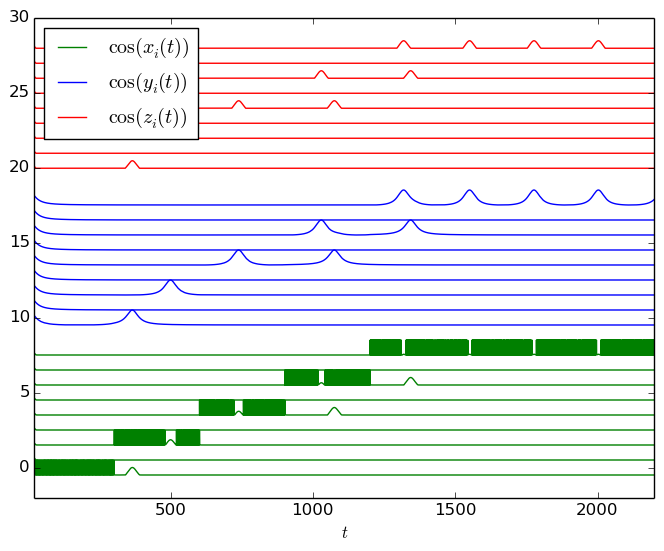

In [21]:
plot(resT,cosX1,color="green")
plot(resT,cosX2,color="green")
plot(resT,cosX3,color="green")
plot(resT,cosX4,color="green")
plot(resT,cosX5,color="green")
plot(resT,cosX6,color="green")
plot(resT,cosX7,color="green")
plot(resT,cosX8,color="green")
plot(resT,cosX9,color="green",label=L"$\cos(x_{i}(t))$")
plot(resT,cosY1,color="blue")
plot(resT,cosY2,color="blue")
plot(resT,cosY3,color="blue")
plot(resT,cosY4,color="blue")
plot(resT,cosY5,color="blue")
plot(resT,cosY6,color="blue")
plot(resT,cosY7,color="blue")
plot(resT,cosY8,color="blue")
plot(resT,cosY9,color="blue",label=L"$\cos(y_{i}(t))$")
plot(resT,cosZ1,color="red")
plot(resT,cosZ2,color="red")
plot(resT,cosZ3,color="red")
plot(resT,cosZ4,color="red")
plot(resT,cosZ5,color="red")
plot(resT,cosZ6,color="red")
plot(resT,cosZ7,color="red")
plot(resT,cosZ8,color="red")
plot(resT,cosZ9,color="red",label=L"$\cos(z_{i}(t))$")
legend(loc=2)
xlabel(L"$t$")
xlim([20.0,2200.0])
ylim([-2.0,30.0])
show()

En la gráfica anterior presentamos la simulación del modelo thalamocortical basado en una red de 9 canales. Las líneas en color verde representan el $\cos_{+}x_{i}(t)$, las líneas en color azul son $\cos_{+}y_{i}(t)$ y las de rojo son $\cos_{+}z_{i}(t)$. En un momento inicial $t=0$ se aplica un estímulo $\sigma_{1}=0.1$. Posteriormente, a un tiempo $t=200$ se aplica un estímulo de mayor fecuencia ($\sigma_{3}=0.3$). Donde solo este último estímulo pasa através de la neocorteza para tiempos mayores a 200. A un tiempo $t=400$, una frecuencia mayor es aplicada ($\sigma_{5}=0.3$); a $t=600$ otro estímulo mayor es aplicado ($\sigma_{3}=0.5$), etc. Podemos observar que en todos los casos solo los extímulos de mayor frecuencia son expresado en la neocorteza.

Ésto último es una confirmación de lo antes mencionado: el cerebro enfoca la atención en los estímulos más persistentes, dejando de lado aquellos de menor amplitud. Nos referimos a la dinámica de la Figura anterior como "el ganador se lleva todo en el dominio de frecuencias". Es decir, el canal con la frecuencia mpas alt de entrada al TH es le único que eventualmente domina la actividad NC, suprimiendo las otras señales.

## Hippocampus


El hipocampus es un sistema altamente complejo, y su funcionamiento es todavía desconocido, aunque este es intensamente estudiado por neurocientíficos y neuroingenieros. Experimentos de respuesta de estímulos están buscando descubrir su rol en la memoria. Lo cual nos impulsa a estudiar sistemas matemáticos análogos y sus respuestas a entradas similares. En particular, aquí nosotros formulamos una red que compara elementos de disparo en ritmos gamma (aproximadamente 40 Hz) pero que pueden ser arrastados en patrones de ritmos theta (aproximadamente 5-12 Hz) por medio de señales de entrada, en analogía con respuestas conocidas del hippocampus a entradas de tanto del septum y de la corteza entorhinal.

Dos de las frecuencias más observadas en la actividad neuronal son las frecuencias gamma y theta:

   - Frecuencia Theta ($\Theta$) (5-12 Hz);
   - Frecuencia Gamma ($\Gamma$) (40+ Hz).

En lo siguiente estudiaremos los distintos patrones de ritmos gamma y theta en un modelo para el hippocampus.

### Modelo de Segmentos del Hippocampus

Una forma de describir la estructura del hippocampus es imaginarlo con un eje largo y dos ejes perpendiculares a éste. Cada dos rebanadas perpendiculares a lo largo del eje contien tres regiones principales, las cuales contienen neuronas excitatorias como inhibitorias. Evidencia experimental sigiere que estas rebabndas pueden sostener oscilaciones sin entradas externas, y las frecuencias naturales de estas oscilaciones están en el rango gamma (40-70 Hz). Como un primer paso para modelar ésto, supondremos que las interacciones entre poblaciones excitatorias e inhibitorias en las rebandas forman un oscilador como en los casos anteriores. Es decir, modelaremos el hippocampus como una cadena de tales osciladores distribuidos a lo largo del eje mayor, como se presenta en la Figura inferior.

Como se puede apreciar en la figura anterior, las dos entradas primarias al hippocampus están relacionadas a la corteza entorhinal (EC) y al medio septum (MS).

Datos morfológicos y neurofisiológicos sugieren que ambas entradas distribuyen sus señales a lo largo de los osciladores hippocampales con apropiados retrasos en fase debido a las diferentes distancias de propagación con respecto a sus fuentes. Ambas entradas suministran estímulos de ritmos theta de baja frecuencia. En lo siguiente, mostraremos que el comportamiento del modelo depende de la desviación en tiempo entre las entradas MS y EC. Además, las frecuencias de las señales de entrada y sus relaciones de fase determinan que osciladores del modelo hippocampal reciben suficientes entradas y, como resultado, un patrón de ritmos theta y gamma en el arreglo de osciladores emergerá. 

En base a la última figura, un modelo de osciladores del hippocampus considera $N$ osciladores que tienen entradas del medio septum (izquierda, en la figura) y de la cortaza entorhinal (derecha). Las señales en el MS y EC tiene fases $\Theta t + \phi_{S}$ y $\Theta t + \phi_{C}$, respectivamente. Las entradas al $i$-ésimo oscilador tiene fases $\theta_{S}=\Theta t + \phi + (N-j)\Delta \Phi$ y $\theta_{C}=\Theta t + \psi + j\Delta \Phi$, respectivamente, donde $\Delta \Phi$ es el lapso de tiempo para que la señal se propague de un segmento al siguiente.

### Análisis del patrón del Modelo del Hippocampus

Sea $\theta$ la fase de un oscilador de segmento, y sean $\theta_{C}$ y $\theta_{S}$ las fases de entrada del EC y MS, respectivamente. El modelo de esta configuración es:

$$\dot{\theta}=\Gamma+K(\cos(\pi+\theta-\theta_{C})+\cos(\pi/2+\theta-\theta_{S}))\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(F)$$

Aquí $\Gamma$ es la freucencia natural de un oscilador del hippocampus ($\Gamma\approx$ 40 Hz). Nosotros supondremos que las fases de las entradas EC y MS son:

$$\theta_{C}=\Theta t +\phi_{C},\mbox{  }\theta_{S}=\Theta t + \phi_{S}\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(G)$$

respectivamente, donde $\Theta\approx$ 5 Hz es la frecuencia de una tirmo theta. Substituyendo la última fórmula obtenemos:

$$\dot{\theta}=\Gamma+2K\sin(\Theta t + \bar{\phi} - \theta)\cos(\psi/2).$$

donde $\psi=\phi_{C}-\phi_{S}$ y $\bar{\phi}=(\phi_{C}+\phi_{S})/2$. Substituyendo $\Phi=\theta-\Theta t -\bar{\phi}$, resulta en la ecuación:

$$\Phi=\Gamma-\Theta-2K\sin\Phi\cos(\psi/2).$$

Este ecuación tendrá un punto estable, denotado por $\Phi^{*}$, si la condición

$$\left| \frac{\Gamma-\Theta}{2K\cos(\psi/2)} \right|\leq1\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot\cdot(H)$$

es satisfecha. De lo cual:

$$\Phi^{*}=\sin^{-1}\left( \frac{\Gamma-\Theta}{2K\cos(\psi/2)} \right)$$

Si $\Phi$ se aproxima al punto de equilibrio $\Phi^{*}$, entonces tendremos que $\theta/t=\Theta+\Phi/t+\bar{\phi}/t\rightarrow\Theta$ conforme $t\rightarrow\infty$. En este caso, el oscilador exhibirá un ritmo Theta. La donción para estabilidad depende de los tres parámetros $K$, $\Gamma-\Theta$, y $\psi$.

### Simulación

El patrón especiotemporal de la actividad neuronal depende de $\psi$, el cual es una desviación de fase entre las dos entradas. Podemos comprobar este cálculo con una simulación computacional de la ecuación (F) usando la condición de estabilidad (H) como una guía para seleccionar los parámetros.

In [44]:
# Definimos las constantes de interes

# Las constantes:
Γ = 40.0*2.0*π
Θ = 5.0
NN = 32
K = 180.0;

Con lo anterior se tiene la base para llevar a cabo la solución numérica, definimos la función que se integrará:

In [58]:
# Función Hippo: determina los coeficientes de la series de Taylor según la ecuación (F)
function Hippo{T<:Real}(vec::Array{T,1} , N::Int, σ, t) # La función pide un arreglo con los puntos alrededor
    # de los cuales se obtendrán las series, el máximo coeficiente N del polinomio de Taylor y σ
    yT = Taylor1(vec[1], N)# Los primeros términos de la serie x0i, y0i y z0i
    for k = 0:N-1
        knext = k+1
        # Las siguientes series contienen los coeficientes hasta k
        # los cuales son necesarios en las ecuaciones de recurrencia
        # para obtener el coeficiente k+1
        yTt = Taylor1( yT.coeffs[1:k+1], k)
        # Las ecuaciones de movimiento, determinadas por (F)
        #even(n) = n == 0 ? true  :  odd(n-1)
        #odd(n)  = n == 0 ? false : even(n-1)
        #if  even(σ)==true
        Dy = -yTt+Γ+2.0*K*cos(π*σ/NN)*sin(Θ*t - yTt)
        #end
        #if odd(σ)==true
         #   Dy = -yTt+Γ+2.0*K*cos(π*σ/NN)*sin(Θ*t - yTt)
        #end
        # Los términos k+1 están determinados por (1)
        yT.coeffs[knext+1]  = Dy.coeffs[knext] / knext
    end
    # Se devuelven los resultados
    return Taylor1[yT]
end

Hippo (generic function with 1 method)

Igual que en los casos anteriores se requiere un integrador, tendremos:

In [59]:
# Función Integrador3: contiene las ecuaciones a resolver usando el método de integración de Taylor
function Integrador3{T<:Real}( vec::Array{T,1}, t_max::Float64, Eqs::Function, epsilon::Float64, N::Int )
    # Usará las funciones antes desarrolladas, este función pide un tiempo máximo de operación, las ecuaciones
    # a resolver, el epsilón y el orden del polinomio de Taylor
    tVFin, yVFin = [], []# Aquí se ubicarán los resultados
    for i=1:2*NN
        σ = i
        t0 = 0.0# Iniciamos el tiempo
        y0 = vec[1]
    
        tV, yV = Float64[], Float64[]# Aquí se ubicarán los resultados
    
        push!(tV, t0)
        push!(yV, y0)# COlocamos condiciones iniciales
    
        # Resolvemos para cada tiempo
        dt = 1.0# Paso inicial
        while t0 < t_max && dt>1.0e-8# Condiciones de paro
            dt, res = evaluador(Eqs,[y0],N,epsilon,σ,t0)# Resolvemos
            t0 += dt# A t0 se le suma el tamaño de paso
            push!(tV,t0)
            push!(yV,res[1])# Los resultados se guardan
            y0 = res[1]
        end
        push!(tVFin,tV)
        push!(yVFin,yV)
    end
    return tVFin, yVFin
end

Integrador3 (generic function with 1 method)

In [60]:
resTH, resθH = Integrador3([1.0], 10.0, Hippo, 10.0^(-15), 20);

In [63]:
resFIN = zeros(NN,1)
dif = zeros(NN,1)
for i=1:NN
    (a,) = size(resθH[2*i])
    resFIN[i] = 10.0*resθH[2*i][a]/(2.0*π*resTH[2*i][a])
    dif[i] = i
end

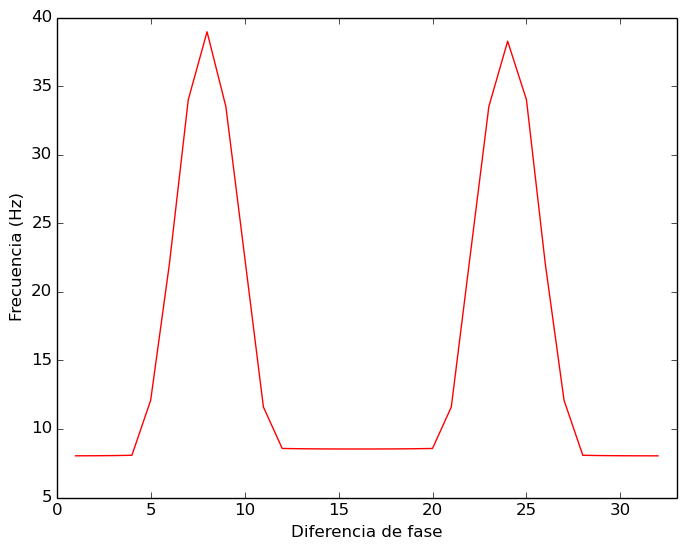

In [68]:
plot(dif,resFIN,color="red",label=L"$\cos(z_{i}(t))$")
xlim([-0.0,33.0])
ylabel("Frecuencia (Hz)")
xlabel("Diferencia de fase")
show()

Como se puede observar, en lo anterior se seleccionó: $\Gamma=40$Hz, $\Gamma=5$Hz, $K=180$, entonces para la condición de equilibrio (H), se tendrá:

$$\left| \frac{\Gamma-\Theta}{2K\cos(\psi/2)} \right|=\frac{0.0972}{|\cos(\psi/2)|}$$

Donde la diferencia de fase $\psi$ se tomó de 1° a 32° y, por tanto, $\cos(\psi/2)\approx1.0$, satisfaciendo la condición (H).

Respecto a la gráfica anterior, podemos decir que el patrón de la actividad neuronal depende de $\psi$, la cual es una desviación de fase entre dos entradas al hippocampus. Además, la gráfica anterior demuestra que la red neuroanl oscila a ritmo theta para algunas desviaciones de fase $\psi$, y este oscila cerca de un ritmo gamma para otras diferencias. En el caso anterior, todos los segmentos oscilatorios son idénticos excpeto para aquellos que reciben las señales de entrada, las cuales difieren de sus vecinos por una cantidad $\psi$, de tal forma que la figura anterior presentan el patrón que es observado a lo largo del eje mayor del modelo cuando se tienen 32 segmentos.

En conclusión, podemos decir que el tiempo de las entradas a un oscilador puede llevar a un importante cambio en la frecuencia de disparo. En particular, varias combinaciones de tiempo pueden crear patrones de actividad de ritmo theta en el arreglo de osciladores. E igualmente, diferentes elecciones de $\psi$ pueden crean otros patrones de ritmo gamma.